# SVM
---

<!-- TABLE OF CONTENTS -->

**IMPORTANT NOTES:** 

**1.** This Notebook will assume a pretty advanced knowledge of SVM's already. More specifically, it will assume all knowledge of these notes: http://cs229.stanford.edu/summer2020/cs229-notes3.pdf

**2.** I also recommend that you download this notebook as sometimes github doesn't render the equations properly.

## Table of Contents: 
1. SVM Defined
2. Optimization of SVM and it's forms
3. List of some well known Kernels
4. Introduction to CVXOPT
5. Converting Dual Form to CVXOPT required form
6. My Implimentation
7. Comparison with sklearn

<br />

---



## SVM Defined


The Support Vector Machine (SVM) is another form of supervised learning of a classifier. Specifically, SVM's are a type of Margin Maximizer that along with a Kernel form the SVM. 


<img src="img/svm_intuition.png" width="400" height="200"> 



<br />

---

## Optimization Problem Forms

### 1. Primal Form
This is the general form from which we can derive the dual form using lagrangian dualality. 

$$
\begin{aligned}
\min _{w, b} & \frac{1}{2}\|w\|^{2} \\
\text { s.t. } & y^{(i)}\left(w^{T} x^{(i)}+b\right) \geq 1, \quad i=1, \ldots, n
\end{aligned}
$$

To gain intuition on why we would want to minmize the norm of $w$ take a look at the above image and remember that the distance from our decision boundry to a support vector is $\frac{1}{\|w\|}$.


### 2. Dual Form

The Dual Form will be our main focus as we can through it into a convex optimizer such as CVXOPT. 

$$
\begin{aligned}
\max _{\alpha} & \; W(\alpha)=\sum_{i=1}^{n} \alpha_{i}-\frac{1}{2} \sum_{i, j=1}^{n} y^{(i)} y^{(j)} \alpha_{i} \alpha_{j}\left\langle x^{(i)}, x^{(j)}\right\rangle \\
\text { s.t. } & \alpha_{i} \geq 0, \quad i=1, \ldots, n \\
& \sum_{i=1}^{n} \alpha_{i} y^{(i)}=0
\end{aligned}
$$

The above equation can be derived using lagrangian duality and will be done it the CS229 notes. Then given the optimal alphas, we can make a prediction on new data:

$$
\begin{aligned}
w^{T} x+b &=\sum_{i=1}^{n} \alpha_{i} y^{(i)}\left\langle x^{(i)}, x\right\rangle+b
\end{aligned}
$$

The derivation of this equation just comes letting out weights be represented as a linear combination of our data points $x$. Specifically let, $w=\sum_{i=1}^{n} \alpha_{i} y^{(i)} x^{(i)}$ then applying this definition of $w$ to our prediction $w^{T} x+b$. Again, this derivation is given in the CS229 notes.






<br />

---


## Kernels

### 1. Gaussian Kernel

$$ K\langle x_{i}, x_{j} \rangle =  exp(- \frac{\| x_{i} - x_{j} \|^2}{2\sigma^2})$$

### 2. Linear Kernel

$$ K\langle x_{i}, x_{j} \rangle = x_{i} \cdot x_{j} $$

### 3. Polynomial Kernel

$$ K\langle x_{i}, x_{j} \rangle = (x_{i} \cdot x_{j} + 1)^d $$

### 4. Sigmoid Kernel

$$ K\langle x_{i}, x_{j} \rangle = \tanh(\mu (x_{i} \cdot x_{j}) + C) $$

### 5. Other Kernels
Some other (and commonly used) kernels are the: 
1. Gaussian Radial Basis Function (RBF) - Default for sklearn SVM 
2. Laplace RBF Kernel 
3. Hyperbolic Tangent Kernel 
4. Bessel Function of First Kind Kernel 
5. Anova Radial Basis Kernel 
6. Linear Spline Kernel in 1D 

Information on "Other Kernels" gathered from: https://data-flair.training/blogs/svm-kernel-functions/



<br />

---

## CVXOPT

CVXOPT (https://cvxopt.org/) is a python library that used quadratic programming for convex optimization. In our case in particular, it solves the convex optimization problem given by the SVM's dual form (as noted above). It takes in a form: 

$$
\begin{array}{ll} 
& \min \frac{1}{2} x^{T} P x+q^{T} x \\
\text { s.t. } & G x \leq h \\
& A x=b
\end{array}
$$

And then outputs the optimal alphas. 

<br />

Though one problem does arise, we need to convert our dual form problem into something recognizable by CVXOPT. That is, we need to find a way to represent $P, q, G, h, A, b$. One article that was intrumental in my understanding of this conversion was: https://xavierbourretsicotte.github.io/SVM_implementation.html. But I have also posted my hand-written notes on this conversion here: https://github.com/ryanirl/ml-basics/blob/main/svm/notes/dual_form_cvxopt_conversion_notes.pdf.

<br />

By default we let $x=\alpha$ and then through some tedious algebra we can repesent $P$, $q$, $G$, $h$, $A$, and $b$ as:


<br />


$$ P := \sum_{i=1}^{n} \sum_{j=1}^{n} y_{i} y_{j} \langle x_{i}, x_{j} \rangle $$


$$ q := -1 $$


$$ G := np.vstack( I_{m} , -I_{m} ) $$

 
$$ h := np.vstack( 0, C ) $$


$$ A := y $$


$$ b := 0 $$


<br />


Where $I_{m}$ is an identity matrix of size $ m \; x \; m $ where the size of $X$ is $ (m, n) $. In other words $m$ is how many points of data we have.

---

In [11]:
# --- Imports --- #

import numpy as np
import matplotlib.pyplot as plt

# For optimization. This is the key ingredient and is the
# quadratic programming library that will be minimizing
# our alphas
import cvxopt

# For easy data points X, y
from sklearn.datasets import make_circles

# For plotting our classifier
from mlxtend.plotting import plot_decision_regions

# For reference of how our classifier performed
from sklearn.svm import SVC


In [12]:
# Create Dataset

# Copied this data set from this acticle: 
# https://towardsdatascience.com/how-to-learn-non-linear-separable-dataset-with-support-vector-machines-a7da21c6d987

# --- Dataset 1 --- # 
np.random.seed(0)

X = np.random.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
y = np.where(y, 1, -1)

# y's are [0, 1] but we need [-1, 1]
y[y == 0] = -1
# ----------------- #

# CVXOPT casts our type int 32 y variable to a float 64 which
# makes in uncompatible for plotting through the MLxtend library
y_int_32 = y

# Conversion to float and sizing. The classifier goes haywire
# without this addition
y = y.reshape(-1,1) * 1.

# If you want circle data points instead
#X, y = make_circles()


In [7]:
# HUGE OVERFITTING PROBLEM
# SOLUTION: RAISE SIGMA VALUE 

def gaussian(x1, x2, sigma = 0.1, axis = 0):
    return np.exp(-(np.linalg.norm(x1 - x2, axis=axis) ** 2) / (2.0 * (sigma ** 2.0)))

In [8]:
# Much of the design is based off of Aladdin Persson's implimentation, his video on SVM with CVXOPT was
# instrumental in my understanding of the CVXOPT library, so huge shoutout to him. The link to his video is:
# https://www.youtube.com/watch?v=gBTtR0bs-1k&list=PLhhyoLH6IjfxpLWyOgBt1sBzIapdRKZmj&index=7
# ANY CODE I KNOWINGLY HARD COPIED FROM HIM WILL BE INITIALED "AP"

class SVM:
    '''
    Much of the function names are bassed on names from sklearn library. The visualization
    library I use (mlxtend) was built for the sklearn library so I mimicked the function
    names in order to get it to work with my from scratch implimentation.

    mlxtend requires SVM to be an class with functions predict and fit
    
    '''

    def __init__(self, kernel = gaussian, sigma = 0.6, C = 1): 
        self.kernal = kernel
        self.sigma = sigma
        self.C = C


    def fit(self, x, y):
        m, n = np.shape(x)
        self.y = y
        self.X = X
        self.gram_matrix = np.zeros((m, m))

        # Kernel K<X, X>
        for i in range(m):
            for j in range(m):
                self.gram_matrix[i][j] = gaussian(X[i], X[j], self.sigma, axis=0) 

        # The following article was a big help in understanding the conversion from dual form
        # to CVXOPT required form and implimenting CVXOPT:
        # https://xavierbourretsicotte.github.io/SVM_implementation.html

        P = cvxopt.matrix(np.outer(y, y) * self.gram_matrix)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((-np.identity(m), np.identity(m))))
        h = cvxopt.matrix(np.vstack((np.zeros((m, 1)), np.ones((m, 1)) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.array([0]), (1, 1), 'd')

        optimal = cvxopt.solvers.qp(P, q, G, h, A, b)
        cvxopt.solvers.options['show_progress'] = True

        self.alphas = np.array(optimal["x"])
      

    def predict(self, X):
        '''
        I will post notes on how we derive a prediction given alphas
        '''

        prediction = np.zeros(len(X))

        S = ((self.alphas > 1e-4)).flatten()

        self.bias = np.mean(self.y[S] - self.alphas[S] * self.y[S] * self.gram_matrix[S, S][:, np.newaxis]) #AP

        # Kernel <X_i, self.X>
        for i in range(len(X)):
            prediction[i] = np.sum(self.alphas[S] * self.y[S] * gaussian(X[i], self.X[S], self.sigma, axis=1)[:, np.newaxis]) #AP
            
        return np.sign(prediction + self.bias) #AP


     pcost       dcost       gap    pres   dres
 0: -4.2942e+01 -3.4327e+02  1e+03  2e+00  8e-16
 1: -3.0263e+01 -1.8500e+02  2e+02  3e-02  9e-16
 2: -3.9805e+01 -6.6433e+01  3e+01  5e-03  8e-16
 3: -4.5939e+01 -5.4105e+01  8e+00  1e-03  8e-16
 4: -4.8241e+01 -5.0366e+01  2e+00  2e-04  8e-16
 5: -4.8953e+01 -4.9284e+01  3e-01  2e-05  9e-16
 6: -4.9081e+01 -4.9103e+01  2e-02  3e-07  9e-16
 7: -4.9090e+01 -4.9091e+01  6e-04  6e-09  8e-16
 8: -4.9091e+01 -4.9091e+01  2e-05  9e-11  1e-15
Optimal solution found.


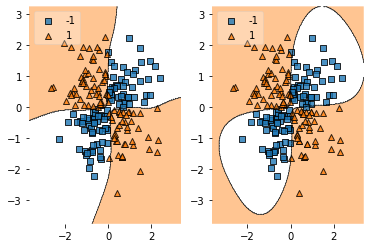

In [9]:
# Multiple Plots 
fig, (ax0, ax1) = plt.subplots(1, 2)

# My Implimentation
model = SVM()
model.fit(X, y)
plot_decision_regions(X, y_int_32, clf=model, legend=2, ax=ax0)

# sklearn Implimentation
sklearn_model = SVC(kernel='rbf')
sklearn_model.fit(X, y_int_32)
plot_decision_regions(X, y_int_32, clf=sklearn_model, legend=2, ax=ax1)

# SHOW PLOT
plt.show()

I would argue that my implimentation (though I did tune the hyperparameters) would generalize better to unseen data than the "vanilla" sklearn would.

Author: RYAN P.